# Evaluate saved model on `data/test_200.h5` and plot residual violins

This notebook evaluates the saved model on the provided test file `../data/test_200.h5`. Steps:
1. Inspect checkpoint (`../pytorch_models/new_mlp_model.pth`) for normalization stats.
2. Build a `SpectralDataset` from `data/test_200.h5` and a test DataLoader.
3. Load the model weights and run inference on the test set.
4. Inverse-transform predictions (using dataset helper or saved mean/std) and save `results/test_predictions.npz`.
5. Produce binned violin plots of residuals for the available target parameters.


In [1]:
# Cell 1: Setup paths and imports
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from torch.utils.data import DataLoader
import inspect

# Paths (adjust if needed)
PROJECT_ROOT = Path('..').resolve()          # notebook lives in results/
sys.path.insert(0, str(PROJECT_ROOT))
TEST_HDF5_PATH = PROJECT_ROOT / 'data' / 'test_normalised.h5'
MODEL_PTH = PROJECT_ROOT / 'pytorch_models' / 'new_mlp_model.pth'
OUT_DIR = PROJECT_ROOT / 'results'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Runtime settings
BATCH_SIZE = 64
DEVICE = 'cpu'   # change to 'cuda' if you have GPU and want to use it

print('Test HDF5:', TEST_HDF5_PATH)
print('Checkpoint:', MODEL_PTH)
print('Output dir:', OUT_DIR)

Test HDF5: /lustre06/project/6016730/minjihk/WEAVE_Pristine/data/test_normalised.h5
Checkpoint: /lustre06/project/6016730/minjihk/WEAVE_Pristine/pytorch_models/new_mlp_model.pth
Output dir: /lustre06/project/6016730/minjihk/WEAVE_Pristine/results


Loaded keys: ['train_loss', 'val_loss']
train_loss shape: (10,)
val_loss shape: (10,)


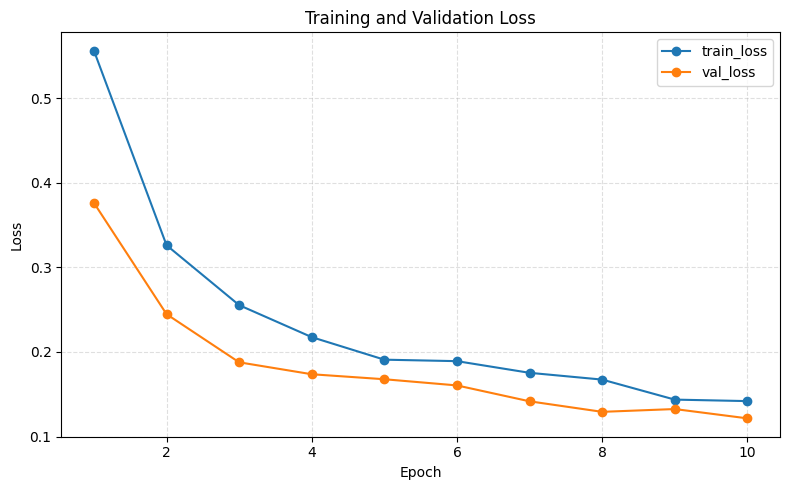

In [2]:
# Cell 2: Plot loss curves (train vs validation)

# Path to the .npz history file - edit this if needed
HISTORY_PATH = Path('../pytorch_models/new_mlp_model.history.npz')

def plot_loss_curves(history_path):
    if not history_path.exists():
        raise FileNotFoundError(f'History file not found: {history_path}')

    data = np.load(history_path, allow_pickle=True)
    print('Loaded keys:', list(data.keys()))

    train_loss = data['train_loss']
    val_loss = data['val_loss']

    print(f'train_loss shape: {train_loss.shape}')
    print(f'val_loss shape: {val_loss.shape}')

    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_loss) + 1)
    ax.plot(epochs, train_loss, marker='o', label='train_loss')
    ax.plot(epochs, val_loss, marker='o', label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_loss_curves(HISTORY_PATH)

Loaded keys: ['train_loss', 'val_loss', 'val_rmse']
train_loss shape: (10,)
val_loss shape: (10,)


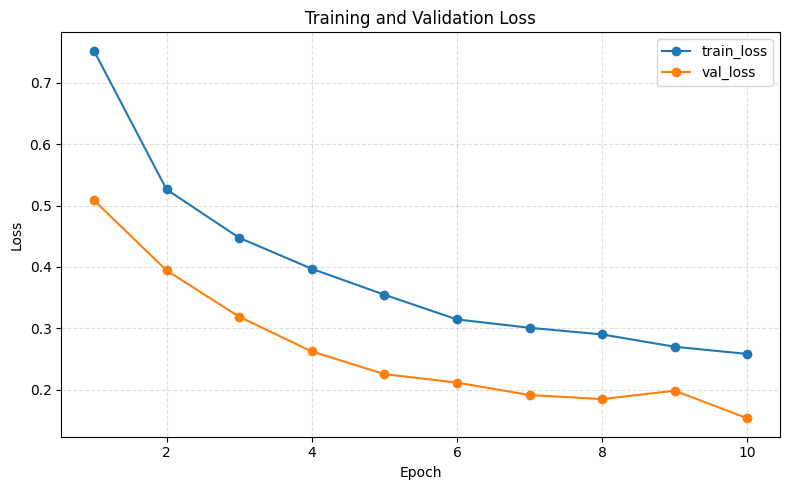

In [ ]:
plot_loss_curves(Path('../pytorch_models/mlp_model.history.npz')) # MLP - 3 layers

In [3]:
# Cell 2: Inspect checkpoint for normalization stats
if not MODEL_PTH.exists():
    raise FileNotFoundError(f'Checkpoint not found: {MODEL_PTH}')

# Load checkpoint (if not loaded already)
if 'ckpt' not in globals():
    # If you previously used safe_globals, keep that approach. Here we just attempt a normal load:
    ckpt = torch.load(MODEL_PTH, map_location=DEVICE, weights_only=False)

print('Checkpoint type:', type(ckpt))
if isinstance(ckpt, dict):
    print('Checkpoint keys:', list(ckpt.keys()))
    has_mean_std = ('target_mean' in ckpt) and ('target_std' in ckpt)
    print('Has target_mean/std in ckpt? ->', has_mean_std)
else:
    print('Checkpoint is not a dict (likely a raw state_dict). No saved mean/std available.')

globals()['ckpt'] = ckpt

Checkpoint type: <class 'dict'>
Checkpoint keys: ['model_state_dict', 'target_mean', 'target_std', 'input_size', 'output_size', 'hidden_layers']
Has target_mean/std in ckpt? -> True


In [4]:
# Cell 3: Instantiate SpectralDataset using the test HDF5 file, and create a DataLoader
try:
    from pytorch_models.spectral_dataset import SpectralDataset, SpectralTransforms
    print('Imported SpectralDataset')
except Exception as e:
    raise RuntimeError('Could not import SpectralDataset from pytorch_models.spectral_dataset: ' + str(e)) from e

# Create dataset (ensure the target_key and use_target_indices match training)
test_dataset = SpectralDataset(
    hdf5_filepath=TEST_HDF5_PATH,
    load_targets=True,
    target_key='original_stellar_parameters',   # adjust if test file uses different key
    use_target_indices=[0, 1, 2, 3],            # Teff, logg, [Fe/H], [a/Fe] (match training)
    transform=SpectralTransforms.standardize,
    device=DEVICE
)

# Apply checkpoint target_mean/target_std to dataset so dataset returns normalized targets
ck = globals().get('ckpt') or globals().get('ck')
if isinstance(ck, dict) and ('target_mean' in ck) and ('target_std' in ck):
    mean = np.array(ck['target_mean'])
    std = np.array(ck['target_std'])
    if hasattr(test_dataset, 'set_target_stats'):
        test_dataset.set_target_stats(mean, std)
        print('Applied checkpoint target_mean/std to `test_dataset` (targets will be normalized).')
    else:
        print('Warning: test_dataset has no set_target_stats method; cannot apply ckpt normalization.')
else:
    print('No target_mean/target_std found in checkpoint; leaving test_dataset target behavior unchanged.')

print('Test dataset length:', len(test_dataset))
globals()['test_dataset'] = test_dataset

Imported SpectralDataset
Data validation passed
SpectralDataset initialized:
  File: /lustre06/project/6016730/minjihk/WEAVE_Pristine/data/test_normalised.h5
  Spectra: 199
  Wavelength points: 6487
  Wavelength range: 4851.92 - 4885.00 Å
  Flux key: flux_normalized
  Load targets: True
  Target key: original_stellar_parameters
  Using target indices: [0, 1, 2, 3]
  Device: cpu
Setting target normalization statistics...
  Mean: [ 5.7365981e+03  3.5043838e+00 -2.2244849e+00  1.2525773e+00]
  Std: [9.9166724e+02 1.0220170e+00 1.5957007e+00 4.3449137e-01]
Applied checkpoint target_mean/std to `test_dataset` (targets will be normalized).
Test dataset length: 199


In [5]:
# Recreate a safe test_loader (no worker processes, small batch)
from torch.utils.data import DataLoader

SAFE_BATCH_SIZE = 16
print('Recreating test_loader with num_workers=0, batch_size=', SAFE_BATCH_SIZE)

test_loader = DataLoader(
    globals().get('test_dataset'),
    batch_size=SAFE_BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

globals()['test_loader'] = test_loader

# Try fetching one batch to verify the dataset returns normalized targets (if applied)
try:
    batch = next(iter(test_loader))
    print('Successfully fetched one batch; type:', type(batch))
    # show shapes/types for inspection
    if isinstance(batch, dict):
        for k, v in batch.items():
            try:
                print(f"  {k}: type={type(v)}, shape={getattr(v, 'shape', 'scalar')}")
            except Exception:
                print(f"  {k}: type={type(v)}")
    elif isinstance(batch, (list, tuple)):
        for i, el in enumerate(batch):
            try:
                print(f'  element {i}: type={type(el)}, shape={getattr(el, "shape", "scalar")}')
            except Exception:
                print(f'  element {i}: type={type(el)}')
    else:
        print('Batch object type:', type(batch))
except Exception as e:
    print('Error while fetching a batch from test_loader (shows exception):', repr(e))

Recreating test_loader with num_workers=0, batch_size= 16
Successfully fetched one batch; type: <class 'list'>
  element 0: type=<class 'torch.Tensor'>, shape=torch.Size([16, 6487])
  element 1: type=<class 'torch.Tensor'>, shape=torch.Size([16, 4])


In [6]:
# Load model class and weights, prepare inverse-transform helper
from importlib import import_module

# Try to import the training MLP class (prefers new_MLP, fallback to MLP)
MLP_class_choice = None
try:
    mod = import_module('pytorch_models.new_MLP')
    MLP_class_choice = getattr(mod, 'MLP', None)
    print('Found MLP in pytorch_models.new_MLP ->', MLP_class_choice is not None)
except Exception:
    MLP_class_choice = None

if MLP_class_choice is None:
    try:
        mod2 = import_module('pytorch_models.MLP')
        MLP_class_choice = getattr(mod2, 'MLP', None)
        print('Found MLP in pytorch_models.MLP ->', MLP_class_choice is not None)
    except Exception:
        pass

if MLP_class_choice is None:
    raise RuntimeError('Could not import an MLP class from pytorch_models (new_MLP or MLP). Please ensure the model class exists.')

ck = globals().get('ckpt')
input_size = None
output_size = None
hidden_layers = None
if isinstance(ck, dict):
    input_size = ck.get('input_size', None)
    output_size = ck.get('output_size', None)
    hidden_layers = ck.get('hidden_layers', None)

# Fallback sizes from dataset if not in checkpoint
if input_size is None:
    try:
        input_size = test_dataset.n_wavelengths
    except Exception:
        input_size = None
if output_size is None:
    try:
        output_size = test_dataset.n_targets
    except Exception:
        output_size = None

print('Model sizes (input, output, hidden):', input_size, output_size, hidden_layers)

# Instantiate model (defensive)
if hidden_layers is not None:
    try:
        model = MLP_class_choice(input_size=input_size or 1, output_size=output_size or 1, hidden_layers=hidden_layers)
    except TypeError:
        model = MLP_class_choice(input_size=input_size or 1, output_size=output_size or 1)
else:
    try:
        model = MLP_class_choice(input_size=input_size or 1, output_size=output_size or 1)
    except TypeError:
        model = MLP_class_choice()

# Load weights (support both raw state_dict and checkpoint-dict)
saved_state = ck.get('model_state_dict') if isinstance(ck, dict) and 'model_state_dict' in ck else ck
try:
    model.load_state_dict(saved_state, strict=True)
    print('Loaded state_dict with strict=True')
except Exception as e:
    print('Strict load failed, retrying with strict=False. Error:', e)
    load_res = model.load_state_dict(saved_state, strict=False)
    print('Load result missing/unexpected keys:', getattr(load_res, 'missing_keys', None), getattr(load_res, 'unexpected_keys', None))

model = model.to(DEVICE)
model.eval()

print('Model loaded. Ready for inference.')

Found MLP in pytorch_models.new_MLP -> True
Model sizes (input, output, hidden): 6487 4 [1024, 512]
Loaded state_dict with strict=True
Model loaded. Ready for inference.
Loaded state_dict with strict=True
Model loaded. Ready for inference.


In [7]:
# Safer inference loop: collect raw preds and truths, then convert both to physical units
import torch

model = globals().get('model')
if model is None:
    raise RuntimeError('No model found in globals; run the model-loading cell first.')
model = model.to(DEVICE)
model.eval()

test_loader = globals().get('test_loader')
if test_loader is None:
    raise RuntimeError('No test_loader found. Run the safe loader cell first.')

# inverse-transform helper (prefer dataset method, then checkpoint mean/std)
ck = globals().get('ckpt') or globals().get('ck')
ds = globals().get('test_dataset', None)

def inverse_targets_np(arr_np):
    # prefer dataset.inverse_transform_target if available
    if ds is not None and hasattr(ds, 'inverse_transform_target'):
        try:
            import torch as _torch
            return ds.inverse_transform_target(_torch.from_numpy(arr_np)).cpu().numpy()
        except Exception:
            pass
    if isinstance(ck, dict):
        mean = ck.get('target_mean', None)
        std = ck.get('target_std', None)
        if mean is not None and std is not None:
            mean = np.array(mean)
            std = np.array(std)
            return arr_np * std + mean
    return arr_np

pred_chunks = []
truth_chunks = []
index_chunks = []
collected_indices = False

iterator = test_loader

try:
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            try:
                # normalize batch parsing to (inputs, targets, maybe indices)
                if isinstance(batch, dict):
                    inputs = batch.get('inputs') or batch.get('spectra') or batch.get('x') or batch.get('data')
                    targets = batch.get('targets') or batch.get('y') or batch.get('labels')
                    batch_idx = batch.get('indices') or batch.get('idx') or batch.get('index')
                elif isinstance(batch, (list, tuple)):
                    if len(batch) == 2:
                        inputs, targets = batch
                        batch_idx = None
                    else:
                        inputs, targets, batch_idx = batch[0], batch[1], (batch[2] if len(batch) > 2 else None)
                else:
                    raise RuntimeError(f'Unsupported batch type: {type(batch)}')

                # convert numpy to tensor if needed
                if isinstance(inputs, np.ndarray):
                    inputs = torch.from_numpy(inputs)
                if isinstance(targets, np.ndarray):
                    targets = torch.from_numpy(targets)

                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)

                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # collect raw numpy arrays
                preds_raw = outputs.cpu().numpy()
                truths_raw = targets.cpu().numpy()

                pred_chunks.append(preds_raw)
                truth_chunks.append(truths_raw)

                if 'batch_idx' in locals() and batch_idx is not None:
                    collected_indices = True
                    if isinstance(batch_idx, torch.Tensor):
                        index_chunks.append(batch_idx.cpu().numpy())
                    elif isinstance(batch_idx, (list, np.ndarray)):
                        index_chunks.append(np.array(batch_idx))
                    else:
                        index_chunks.append(np.array([batch_idx]))

            except Exception as batch_exc:
                print(f'Error in batch {i}:', repr(batch_exc))
except Exception as e:
    print('Unexpected error during inference loop (caught):', repr(e))

# Concatenate
if len(pred_chunks) == 0:
    raise RuntimeError('No predictions collected (maybe all batches errored).')

preds_raw = np.concatenate(pred_chunks, axis=0)
truths_raw = np.concatenate(truth_chunks, axis=0)
if collected_indices and len(index_chunks) > 0:
    indices = np.concatenate(index_chunks, axis=0)
else:
    ds_for_indices = getattr(test_loader, 'dataset', None)
    if ds_for_indices is not None and hasattr(ds_for_indices, 'indices'):
        indices = np.array(ds_for_indices.indices)
    else:
        indices = np.arange(len(preds_raw))

print('Collected raw preds shape:', preds_raw.shape, 'raw truths shape:', truths_raw.shape, 'indices shape:', indices.shape)

# Apply inverse transform to both preds and truths to get physical units
preds_phys = inverse_targets_np(preds_raw)
truths_phys = inverse_targets_np(truths_raw)
residuals_phys = preds_phys - truths_phys

out_npz = Path('..') / 'results' / 'test_predictions_normalized_labels.npz'
np.savez(out_npz,
         indices=indices,
         preds_raw=preds_raw,
         truths_raw=truths_raw,
         preds_phys=preds_phys,
         truths_phys=truths_phys,
         residuals_phys=residuals_phys)
print('Saved test predictions (raw + physical) to', out_npz)

# expose in globals for plotting cells
globals()['test_preds_raw'] = preds_raw
globals()['test_truths_raw'] = truths_raw
globals()['test_preds'] = preds_phys        # keep notebook compatibility (test_preds = physical preds)
globals()['test_truths'] = truths_phys
globals()['test_residuals'] = residuals_phys
globals()['indices'] = indices

Collected raw preds shape: (199, 4) raw truths shape: (199, 4) indices shape: (199,)
Saved test predictions (raw + physical) to ../results/test_predictions_normalized_labels.npz


/tmp/ipykernel_2916633/457530375.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(x) for x in tick_positions])


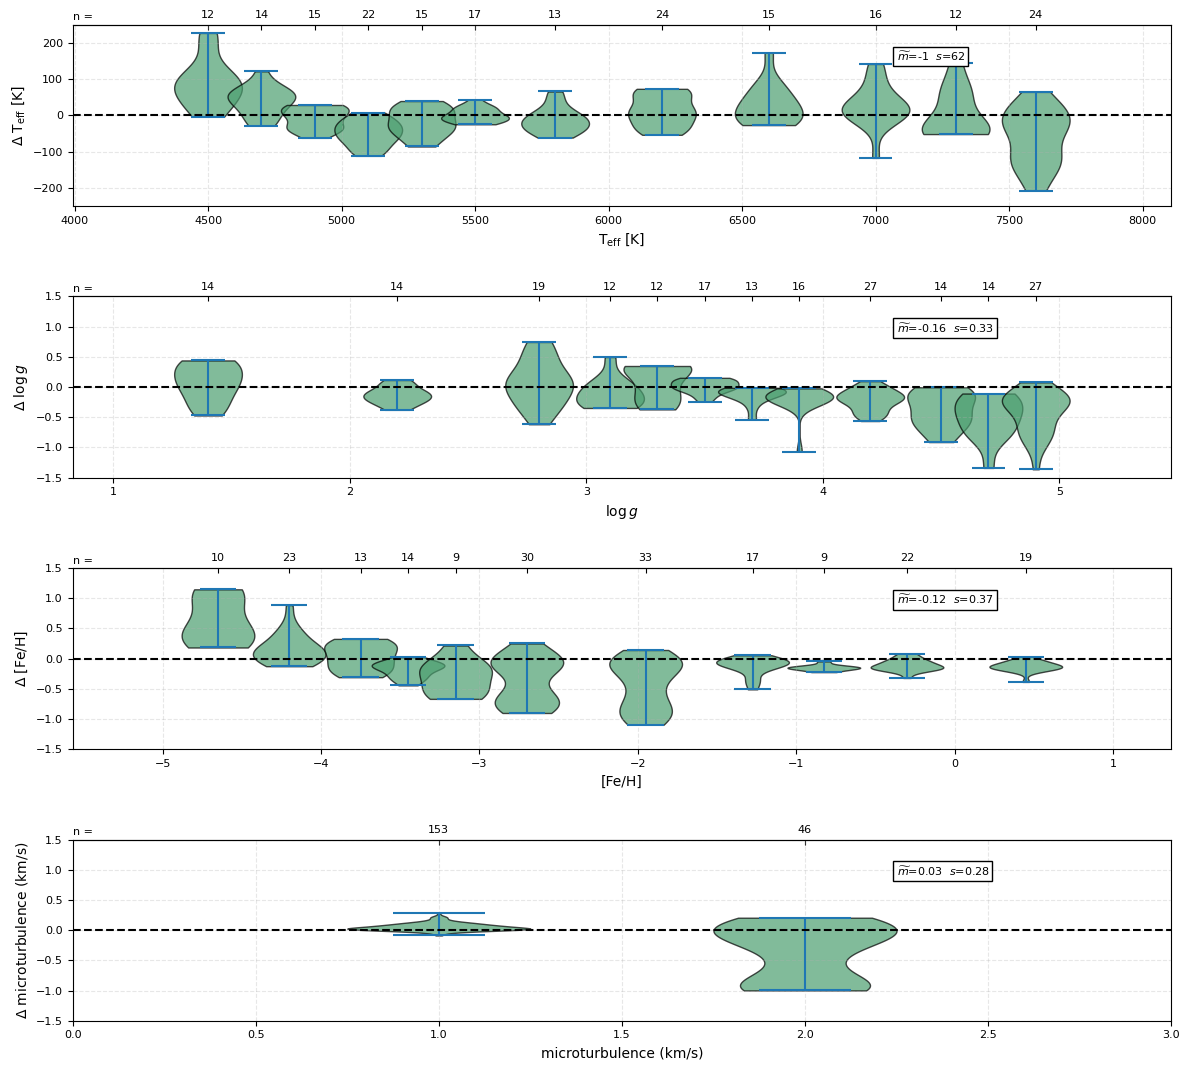

In [8]:
# Binned residual-violin plotting utility (ready to run)
# Default parameter names & mapping from short keys to column indices
param_names_default = ['Teff (K)', 'logg', '[Fe/H]', 'microturbulence']
label_key_to_idx = {'teff': 0, 'logg': 1, 'feh': 2, 'micro': 3}

def plot_resid_violin_binned(label_keys=None,
                             preds=None,
                             truths=None,
                             n_bins=10,
                             bin_method='quantile',   # 'quantile' or 'linear'
                             min_count=5,
                             y_lims=None,
                             savename=None,
                             figsize_per_row=2.7):
    """
    Make binned violin plots of residuals (pred - truth) for each requested label.
    - label_keys: list like ['teff','logg','feh','micro'] or None to use all defaults
    - preds, truths: numpy arrays shape (N, n_params). If None, uses globals 'preds' and 'truths'.
    - n_bins: number of bins along the target domain (if domain has <= n_bins unique values, uses those unique values)
    - bin_method: 'quantile' (equal-count bins) or 'linear' (equal-width bins)
    - min_count: minimum samples in a bin to include it in the plot
    - y_lims: list/tuple of per-parameter +/- y-limits (optional). If None, computed automatically per parameter
    - savename: optional path to save the figure
    """
    # grab preds/truths from globals if not provided
    preds = preds if preds is not None else globals().get('preds', None)
    truths = truths if truths is not None else globals().get('truths', None)
    if preds is None or truths is None:
        raise RuntimeError("preds and truths not found: pass them or run evaluation cell first.")

    preds = np.asarray(preds)
    truths = np.asarray(truths)
    if preds.shape != truths.shape:
        raise RuntimeError(f"preds and truths must have same shape, got {preds.shape} vs {truths.shape}")

    n_params = preds.shape[1]
    if label_keys is None:
        # default order: teff, logg, feh, micro (truncate to available params)
        label_keys = ['teff','logg','feh','micro'][:n_params]

    # prepare figure
    n_plots = len(label_keys)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots * figsize_per_row), squeeze=False)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)

    for i, key in enumerate(label_keys):
        ax = axes[i,0]
        idx = label_key_to_idx.get(key, None)
        if idx is None or idx >= n_params:
            raise KeyError(f"Unknown or out-of-range label key '{key}' (requested index {idx})")

        pretty_name = key
        if key == 'teff':
            pretty_name = 'T$_{\\mathrm{eff}}$ [K]'
        elif key == 'feh':
            pretty_name = '[Fe/H]'
        elif key == 'logg':
            pretty_name = '$\\log{g}$'
        elif key == 'micro':
            pretty_name = 'microturbulence (km/s)'

        tgt_vals = truths[:, idx]
        diff = preds[:, idx] - truths[:, idx]

        # Choose bin edges
        unique_vals = np.unique(tgt_vals)
        if unique_vals.size <= n_bins:
            # use exact unique values as "bins"
            bin_centers = unique_vals
            box_data = []
            box_positions = []
            for val in bin_centers:
                sel = np.where(tgt_vals == val)[0]
                if len(sel) >= min_count:
                    box_positions.append(val)
                    box_data.append(diff[sel])
            if len(box_positions) == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            box_positions = np.array(box_positions)
            box_width = np.mean(np.diff(np.sort(box_positions))) / 2 if box_positions.size>1 else 0.5
        else:
            # regular binning
            if bin_method == 'quantile':
                quantiles = np.linspace(0, 1, n_bins + 1)
                edges = np.unique(np.quantile(tgt_vals, quantiles))
                # if edges collapsed because of duplicates, fallback to linear
                if len(edges) <= 2:
                    edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)
            else:
                edges = np.linspace(tgt_vals.min(), tgt_vals.max(), n_bins + 1)

            box_positions = []
            box_data = []
            for j in range(len(edges)-1):
                low, high = edges[j], edges[j+1]
                if j == len(edges)-2:
                    # include rightmost edge
                    sel = np.where((tgt_vals >= low) & (tgt_vals <= high))[0]
                else:
                    sel = np.where((tgt_vals >= low) & (tgt_vals < high))[0]
                if len(sel) >= min_count:
                    center = (low + high) / 2.0
                    box_positions.append(center)
                    box_data.append(diff[sel])
            box_positions = np.array(box_positions)
            if box_positions.size == 0:
                ax.text(0.5, 0.5, 'No bins with >= min_count samples', ha='center', va='center')
                continue
            # choose a sensible width
            if box_positions.size > 1:
                spacing = np.mean(np.diff(np.sort(box_positions)))
                box_width = spacing * 0.9
            else:
                # single bin
                span = (edges[-1] - edges[0]) if edges is not None else 1.0
                box_width = span * 0.2

        # Plot violins
        parts = ax.violinplot(box_data, positions=box_positions, widths=box_width,
                              showextrema=True, showmeans=False)
        for pc in parts['bodies']:
            pc.set_facecolor('#4C9F70')
            pc.set_edgecolor('black')
            pc.set_alpha(0.7)
        if 'cmedians' in parts:
            parts['cmedians'].set_color('black')

        # Annotate median and standard deviation of residuals (global for that parameter)
        med = np.median(diff)
        std_ = np.std(diff)
        if 'eff' in pretty_name:
            ann = '$\\widetilde{m}$=%0.0f  $s$=%0.0f' % (med, std_)
        elif 'rad' in pretty_name:
            ann = '$\\widetilde{m}$=%0.1f  $s$=%0.1f' % (med, std_)
        else:
            ann = '$\\widetilde{m}$=%0.2f  $s$=%0.2f' % (med, std_)
        ax.annotate(ann, (0.75, 0.8), size=8, xycoords='axes fraction', bbox=bbox_props)

        # Axes labels, grid, zero line
        ax.set_xlabel(f'{pretty_name}')
        ax.set_ylabel(r'$\Delta$ %s' % pretty_name)
        ax.axhline(0, linewidth=1.5, c='black', linestyle='--')

        # y-limits
        if y_lims is not None:
            # if y_lims provided as list per param, pick ith or scalar
            if isinstance(y_lims, (list, tuple, np.ndarray)):
                if len(y_lims) >= len(label_keys):
                    yl = y_lims[i]
                else:
                    yl = y_lims[0]
            else:
                yl = y_lims
            ax.set_ylim(-yl, yl)
        else:
            # auto compute: a few times the median absolute deviation / percentile
            rng = np.percentile(np.abs(diff), 98)
            yl = max(rng * 1.2, np.std(diff) * 3, 1e-8)
            ax.set_ylim(-yl, yl)

        # x-limits & ticks
        ax.set_xlim(np.min(box_positions) - box_width*2, np.max(box_positions) + box_width*2)
        ax.tick_params(labelsize=8)
        ax.grid(True, linestyle='--', alpha=0.3)

        # Annotate sample size of each bin on top as ticklabels
        ax.text(box_positions[0] - 2*box_width, 1.05 * ax.get_ylim()[1], 'n = ', fontsize=8)
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(box_positions)
        ax_t.set_xticklabels([len(d) for d in box_data])
        ax_t.tick_params(axis='x', direction='in', labelsize=8)

        # If Teff, set integer ticks
        if key == 'teff':
            tick_positions = ax.get_xticks()
            ax.set_xticklabels([int(x) for x in tick_positions])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)

    if savename is not None:
        path = Path(savename)
        fig.savefig(path, facecolor='white', transparent=False, dpi=150, bbox_inches='tight', pad_inches=0.05)
        print(f"Saved figure to {path}")

    plt.show()


# Example call using globals 'preds' and 'truths' computed earlier
# Default: 10 quantile bins, require at least 5 samples per bin
plot_resid_violin_binned(label_keys=['teff','logg','feh','micro'],
                         preds=globals().get('test_preds'),
                         truths=globals().get('test_truths'),
                         n_bins=12,
                         bin_method='quantile',
                         min_count=1,
                         y_lims=[250, 1.5, 1.5, 1.5])

### Distribution of raw data (and processed data)

In [27]:
import h5py

def inspect_hdf5(path, metadata_group = None):
    with h5py.File(path, 'r') as f:
        print(f"\nGroups/datasets in {path}:")
        def print_items(name, obj):
            print(f"  {name} ({'Group' if isinstance(obj, h5py.Group) else 'Dataset'})")
        f.visititems(print_items)

        if metadata_group is not None:
            # Print all metadata attributes
            print("Metadata group attributes:")
            for key, value in f[metadata_group].attrs.items():
                print(f"  {key}: {value}")

# Inspect both files
inspect_hdf5("../data/processed_spectra.h5")
inspect_hdf5("../data/weave_nlte_grids.h5", "metadata")


Groups/datasets in ../data/processed_spectra.h5:
  continuum_fits (Dataset)
  flux_normalized (Dataset)
  original_parameter_names (Dataset)
  original_stellar_parameters (Dataset)
  wavelength (Dataset)

Groups/datasets in ../data/weave_nlte_grids.h5:
  labels (Group)
  labels/filenames (Dataset)
  labels/stellar_parameters (Dataset)
  metadata (Group)
  spectra (Group)
  spectra/flux (Dataset)
  spectra/wavelength_grid (Dataset)
Metadata group attributes:
  n_spectra: 19393
  stellar_param_names: ['teff' 'log_g' 'metallicity' 'microturbulence' 'macroturbulence' 'vsini']


In [24]:
def plot_label_histograms(col: int, label_name: str):
    # Paths to your HDF5 files (relative to results/)
    processed_path = "../data/processed_spectra.h5"
    nlte_path = "../data/weave_nlte_grids.h5"

    # Load [alpha/H] from processed_spectra.h5 (column 3 of original_stellar_parameters)
    with h5py.File(processed_path, 'r') as f:
        params_processed = f['original_stellar_parameters'][:]
        alpha_processed = params_processed[:, col]

    # Load [alpha/H] from weave_nlte_grids.h5 (column 3 of labels/stellar_parameters)
    with h5py.File(nlte_path, 'r') as f:
        params_nlte = f['labels/stellar_parameters'][:]
        alpha_nlte = params_nlte[:, col]

    # Plot histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    axes[0].hist(alpha_processed, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
    axes[0].set_title(f"True {label_name} in processed_spectra.h5")
    axes[0].set_xlabel(label_name)
    axes[0].set_ylabel("Count")

    axes[1].hist(alpha_nlte, bins=20, color='darkorange', alpha=0.7, edgecolor='black')
    axes[1].set_title(f"True {label_name} in weave_nlte_grids.h5")
    axes[1].set_xlabel(label_name)

    plt.tight_layout()
    plt.show()

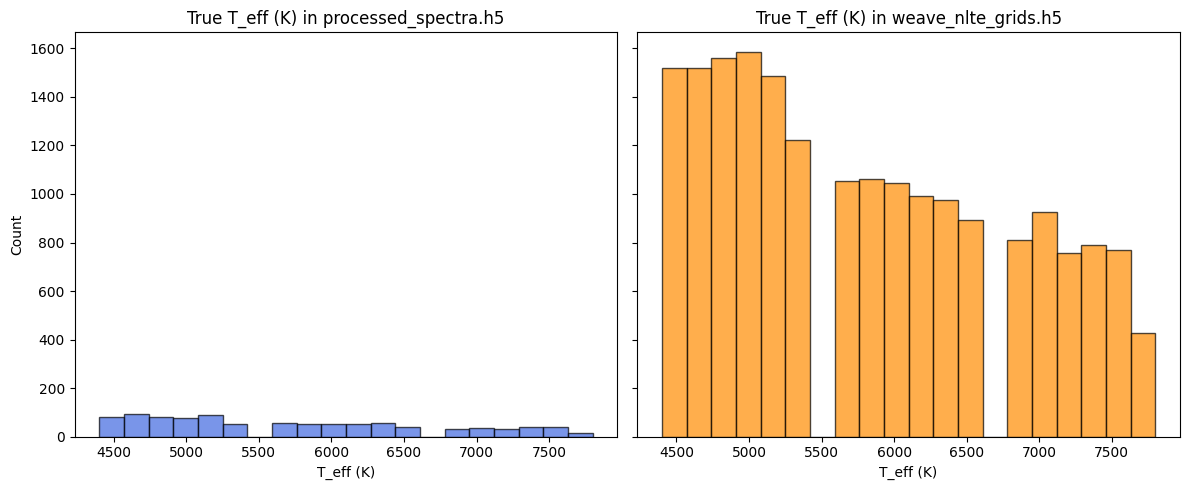

In [28]:
plot_label_histograms(0, 'T_eff (K)')  # Teff